In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            #nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            #nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 2

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [5]:
# Load
PATH_enc = 'encoder_conv_autoenc.pt'
PATH_dec = 'decoder_conv_autoenc.pt'
encoder.load_state_dict(torch.load(PATH_enc))
encoder.eval()
decoder.load_state_dict(torch.load(PATH_dec))
decoder.eval()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [6]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.03932034969329834

tensor([-0.0115, -0.1634])
tensor([0.8777, 1.3607])


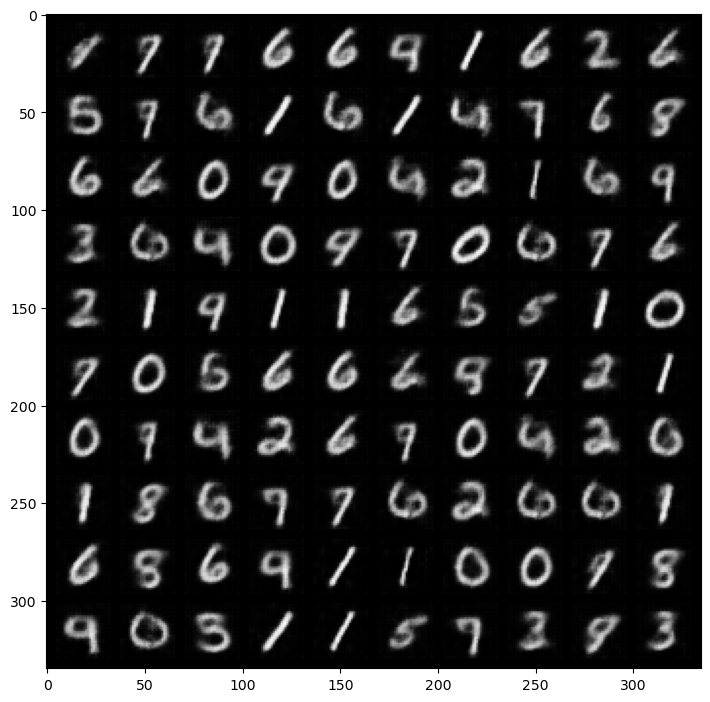

In [7]:
#generate samples from latnt code
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean
    #print(latent)
    #print(latent.shape)

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [8]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
from tqdm import tqdm

In [10]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3144.34it/s]


Enc. Variable 0  Enc. Variable 1  label
0            0.240591         0.286738      7
1           -0.607497        -0.340900      2
2            0.161667         2.805163      1
3           -0.585463        -1.994725      0
4            0.570041        -0.280448      4
...               ...              ...    ...
9995        -1.036740        -0.070023      2
9996        -0.075183        -0.534253      3
9997         0.057888         0.203255      4
9998        -0.553849         0.327204      5
9999        -0.585187        -1.194946      6

[10000 rows x 3 columns]

In [11]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

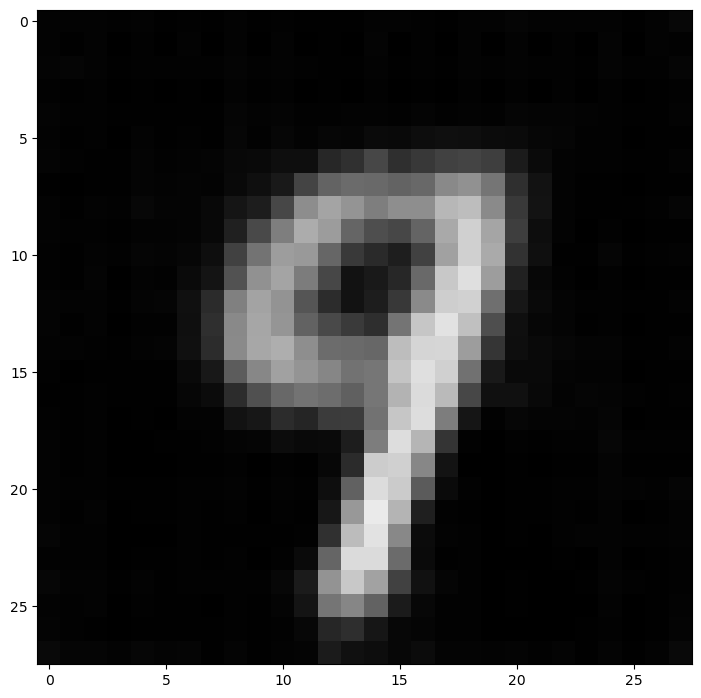

torch.Size([1, 2])


In [12]:
#auxiliary stuff
latent = torch.tensor([[0.5, 0.2]])
latent = latent.to(device)
img_recon = decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
plt.show()
print(latent.shape)

In [13]:
#Let us take a uniform grid on the latent space. Note that here d=2. The bounds for the grid can be taken from 3 sigma rule. 
#We will take 2 sigmas however
numsteps = 10
xs = torch.linspace(mean[0]-2*std[0], mean[0]+2*std[0], steps = numsteps)
ys = torch.linspace(mean[1]-2*std[1], mean[1]+2*std[1], steps = numsteps)
uniform_grid = torch.cartesian_prod(xs,ys)

In [14]:
uniform_grid.shape

torch.Size([100, 2])

In [15]:
h = float((xs[numsteps-1]-xs[0])/numsteps)
print(h)

0.3510788679122925


In [16]:
#print(uniform_grid)

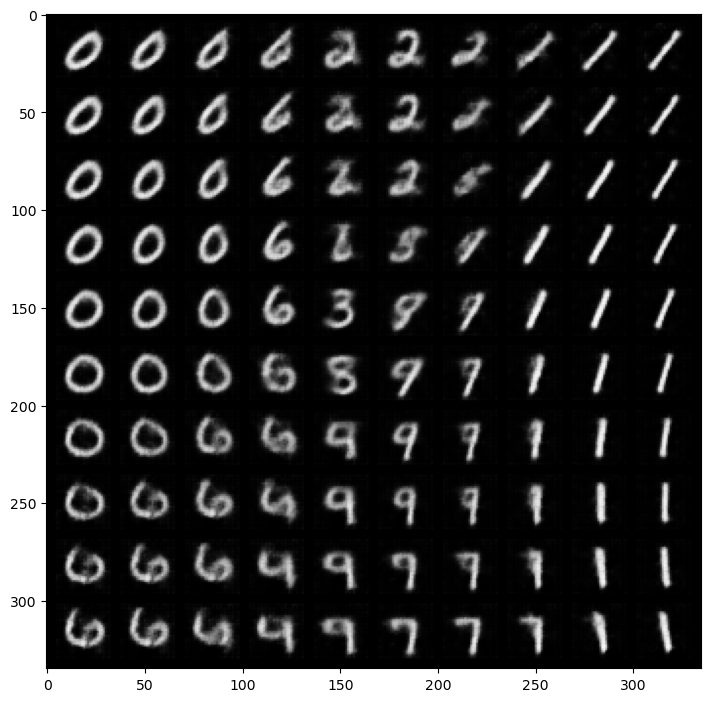

torch.Size([100, 2])
torch.Size([100, 1, 28, 28])


In [17]:
#Manifold plot
latent = uniform_grid
latent = latent.to(device)
img_recon = decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
plt.show()
print(latent.shape)
print(img_recon.shape)

# Heatmap of the Frobenius norm

In [23]:
#let us do it on the grid
#first let us make a function
#h = 0.03
def my_g(u,h): #this gives metric at point u with step h
    dpsidx = (decoder(u + torch.tensor([[0.0 + h, 0.0]])) - decoder(u + torch.tensor([[0.0 - h, 0.0]])))/(2*h)
    dpsidy = (decoder(u + torch.tensor([[0.0, 0.0 + h]])) - decoder(u + torch.tensor([[0.0, 0.0 - h]])))/(2*h)
    my_metric = torch.tensor([[(dpsidx*dpsidx).sum(),(dpsidx*dpsidy).sum()],
                             [(dpsidx*dpsidy).sum(),(dpsidy*dpsidy).sum()]])
    return my_metric

In [24]:
g00 = my_g(torch.tensor([[0,0]]),0.03)

In [25]:
torch.linalg.det(g00)

tensor(118849.3984)

In [26]:
torch.linalg.norm(g00) # frobenius norm

tensor(752.6102)

In [27]:
#this is done in a bad way
numsteps = 10
xs = np.linspace(float(mean[0]-2*std[0]), float(mean[0]+2*std[0]), numsteps)
ys = np.linspace(float(mean[0]-2*std[0]), float(mean[0]+2*std[0]), numsteps)
#grid = meshgid(xs,ys)
h = float((xs[numsteps-1] - xs[0])/numsteps)
FrobNormGrid = torch.zeros(numsteps, numsteps)

In [30]:
float(h)

0.3510788679122925

In [31]:
#this is done in a bad way

i = 0
for x in xs:
    j = 0
    for y in ys:
        FrobNormGrid[i, j] = torch.linalg.norm(my_g(torch.tensor([[float(x), float(y)]]),h))
        #FrobNormGrid[i, j] = 
        #print(torch.linalg.norm(my_g(torch.tensor([[float(x), float(y)]]))))
        j+=1
    i+=1
print(FrobNormGrid)

tensor([[ 27.1396,  23.3355,  19.6430,  51.7177,  42.4360,  47.3234,  56.6054,
          46.7266,  42.6739,  33.8942],
        [ 36.2072,  41.8717,  28.1457,  61.9358,  51.4757,  56.5102,  71.6640,
          39.0326,  46.2202,  36.1548],
        [ 57.2336,  66.4060,  63.8441,  82.4245,  51.7208, 100.1908,  49.8172,
          62.3634,  49.2266,  34.6889],
        [ 66.3035,  89.1459, 109.2970, 101.7042,  77.0718,  88.8521,  68.2943,
          57.0949,  41.3328,  39.6623],
        [ 74.4448,  86.3297, 115.3719, 139.0602, 123.2374,  74.8594,  69.5070,
          53.2104,  47.5977,  42.1842],
        [ 70.1393,  44.7947,  81.7874, 122.3121, 131.7713,  91.7091,  64.5807,
          50.0203,  49.4661,  45.9790],
        [ 81.0233,  37.4266,  63.8596,  98.9501,  74.5513,  92.2569,  48.7103,
          33.4318,  32.8460,  42.0639],
        [ 36.5149,  40.9383,  69.7867,  67.6321,  80.5530,  55.4803,  37.6046,
          28.5131,  24.9559,  28.9084],
        [ 40.6857,  75.4429,  59.8472,  79.5672,

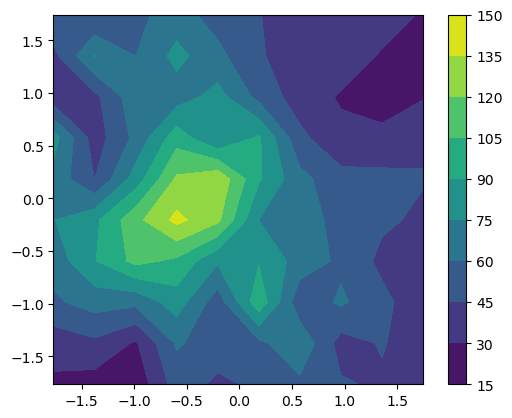

In [32]:
#Heat map of the frobenius norm
h = plt.contourf(xs, ys, FrobNormGrid)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [ ]:
# Let us rewrite the metric function so that it would take the grid of points and give out the metric evaluated on a grid

# Differentiation with the help of torch.roll

In [34]:
#what if we differentiate all at once? This should be faster
numsteps = 10
xs = torch.linspace(mean[0]-2*std[0], mean[0]+2*std[0], steps = numsteps)
ys = torch.linspace(mean[1]-2*std[1], mean[1]+2*std[1], steps = numsteps)
uniform_grid = torch.cartesian_prod(xs,ys)

latent1 = uniform_grid

latent1 = latent1.to(device)
toto = decoder(latent1)
print( toto.shape )

torch.Size([100, 1, 28, 28])


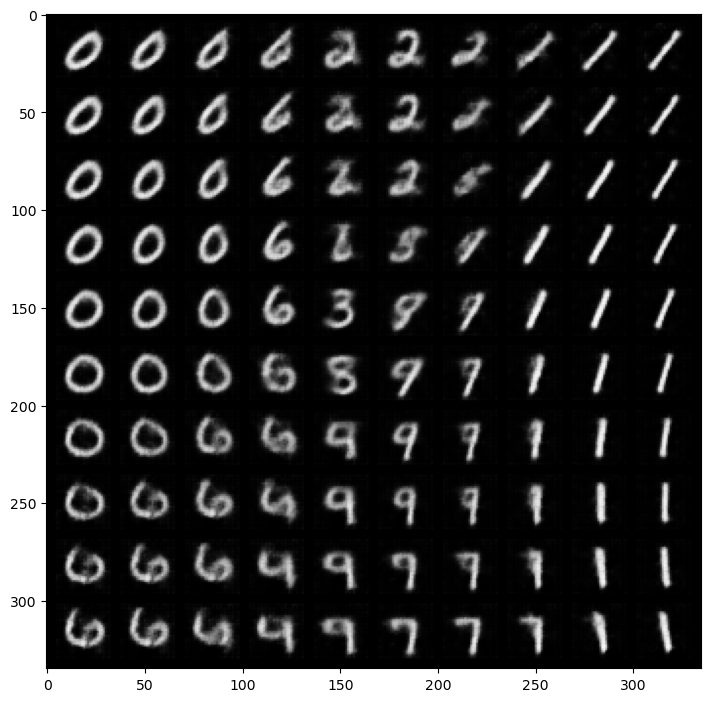

In [35]:
#manifold plot

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(toto[:100],10,5))
plt.show()

In [36]:
# shift along x axis
toto_shiftx = toto.roll(1,0)

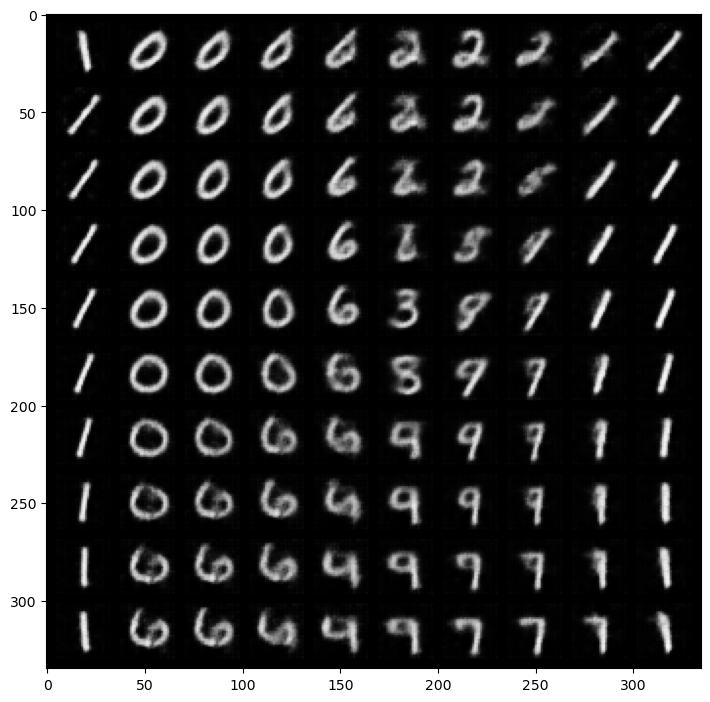

In [37]:
#manifold plot with a shift wrt to x axis

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(toto_shiftx[:100],10,5))
plt.show()

In [38]:
# shift along y axis
toto_shifty = toto.roll(10,0)

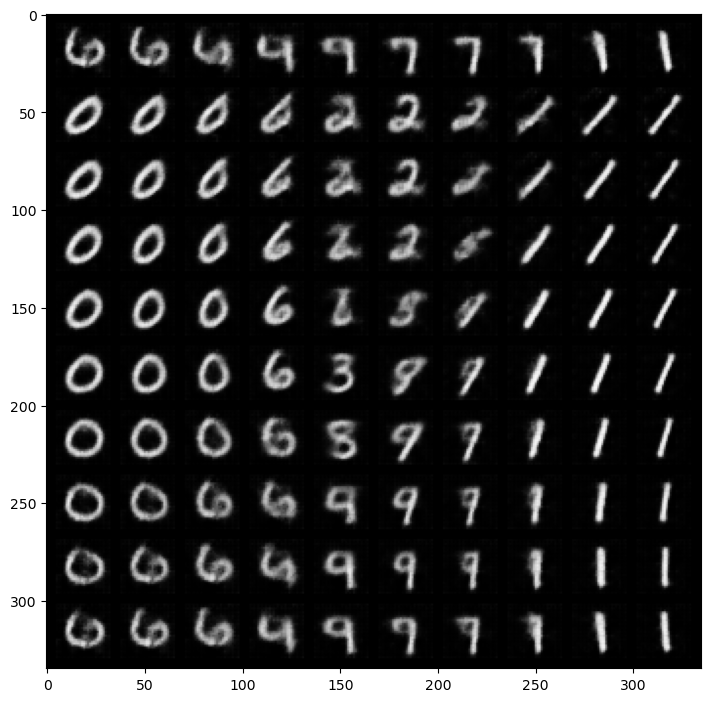

In [39]:
#manifold plot with a shift wrt to y axis

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(toto_shifty[:100],10,5))
plt.show()

In [40]:
toto_shifty_neg = toto.roll(-10,0)

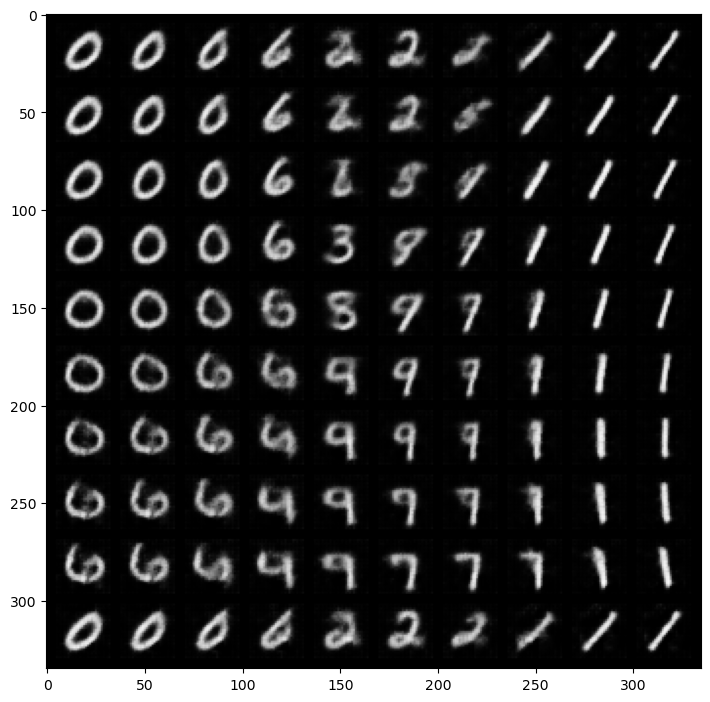

In [41]:
#manifold plot with a negative shift wrt to y axis

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(toto_shifty_neg[:100],10,5))
plt.show()

# Metric on a grid over the latent space

In [42]:
#Let us take a uniform grid on the latent space. Note that here d=2. The bounds for the grid can be taken from 3 sigma rule. 
#We will take 2 sigmas however
numsteps = 100
xs = torch.linspace(mean[0]-2*std[0], mean[0]+2*std[0], steps = numsteps)
ys = torch.linspace(mean[1]-2*std[1], mean[1]+2*std[1], steps = numsteps)
uniform_grid = torch.cartesian_prod(xs,ys)

In [43]:
#metric on a grid
def g(grid):
    numsteps = int(np.sqrt(grid.shape[0]))
    hx = float(abs((uniform_grid[numsteps**2 - 1] - uniform_grid[0])[0]))/numsteps 
    hy = float(abs((uniform_grid[numsteps - 1] - uniform_grid[0])[1]))/numsteps
    latent = grid
    latent = latent.to(device)
    psi = decoder(latent)
    psi_next_x =  psi.roll(-1,0)
    psi_prev_x =  psi.roll(1,0)
    psi_next_y =  psi.roll(-numsteps,0)
    psi_prev_y =  psi.roll(numsteps,0)
    dpsidx = (psi_next_x - psi_prev_x)/(2*hx)
    dpsidy = (psi_next_y - psi_prev_y)/(2*hy)
    metric = torch.cat(((dpsidx*dpsidx).sum((1,2,3)),(dpsidx*dpsidy).sum((1,2,3)),(dpsidx*dpsidy).sum((1,2,3)),(dpsidy*dpsidy).sum((1,2,3))),0)
    metric = metric.view(4, numsteps*numsteps)
    metric = metric.transpose(0, 1)
    return metric

In [44]:
with torch.no_grad():
    print(g(uniform_grid))

tensor([[ 2.0477e+04,  6.7941e+03,  6.7941e+03,  7.3543e+03],
        [ 5.1385e+01, -1.9491e+01, -1.9491e+01,  7.3757e+03],
        [ 5.4393e+01, -2.6932e+01, -2.6932e+01,  7.3870e+03],
        ...,
        [ 2.3219e+01,  5.4225e+00,  5.4225e+00,  5.8620e+03],
        [ 2.6117e+01,  2.6270e+01,  2.6270e+01,  5.8030e+03],
        [ 2.0665e+04,  4.6760e+03,  4.6760e+03,  5.7250e+03]])


In [45]:
#simultaneous differentiation on a grid with torch.roll
def diff_by_x(tensor, numsteps, h):
    psi = tensor
    psi_next_x =  psi.roll(-1,0)
    psi_prev_x =  psi.roll(1,0)
    dpsidx = (psi_next_x - psi_prev_x)/(2*h)
    return dpsidx
def diff_by_y(tensor, numsteps, h):
    psi = tensor
    psi_next_y =  psi.roll(-numsteps,0)
    psi_prev_y =  psi.roll(numsteps,0)
    dpsidy = (psi_next_y - psi_prev_y)/(2*h)
    return dpsidy
    

In [46]:
#derivatives of the metric on a grid
def dg_grid (grid): #dg
    
    numsteps = int(np.sqrt(grid.shape[0]))
    hx = float(abs((uniform_grid[numsteps**2 - 1] - uniform_grid[0])[0]))/numsteps 
    hy = float(abs((uniform_grid[numsteps - 1] - uniform_grid[0])[1]))/numsteps
    latent = grid
    latent = latent.to(device)
    psi = decoder(latent)
    
    dpsidx = diff_by_x(psi, numsteps, hx)
    dpsidy = diff_by_x(psi, numsteps, hy)
    dpsidx_second = diff_by_x(dpsidx, numsteps, hx)
    dpsidx_dy = diff_by_y(dpsidx, numsteps, hy)
    dpsidy_second = diff_by_y(dpsidy, numsteps, hy)
    
    #metric = torch.cat(((dpsidx*dpsidx).sum((1,2,3)),(dpsidx*dpsidy).sum((1,2,3)),
    #                  (dpsidx*dpsidy).sum((1,2,3)),(dpsidy*dpsidy).sum((1,2,3))),0)
    
    dgdx = torch.cat((2*(dpsidx*dpsidx_second).sum((1,2,3)),(dpsidx_second * dpsidy + dpsidx * dpsidx_dy).sum((1,2,3)),
                      (dpsidx_second * dpsidy + dpsidx * dpsidx_dy).sum((1,2,3)),2*(dpsidy * dpsidx_dy).sum((1,2,3))),0)
    dgdy = torch.cat((2*(dpsidx*dpsidx_dy).sum((1,2,3)),(dpsidy_second * dpsidx + dpsidy * dpsidx_dy).sum((1,2,3)),
                      (dpsidy_second * dpsidx + dpsidy * dpsidx_dy).sum((1,2,3)),2*(dpsidy*dpsidy_second).sum((1,2,3))),0)
    metric_der = torch.cat((dgdx, dgdy), 0)
    metric = metric_der
    metric = metric.view(8, numsteps*numsteps)
    metric = metric.transpose(0, 1)
    metric = metric.view(numsteps*numsteps, 2, 4)
    return metric

In [47]:
# compute the grid of metric derivatives
with torch.no_grad():
    metric_der = dg_grid(uniform_grid)
    metric_der = metric_der.view(numsteps*numsteps, 2, 2, 2)


In [48]:
# compute the grid of metric
with torch.no_grad():
    metric = g(uniform_grid)
    metric = metric.view(numsteps*numsteps, 2, 2)

In [49]:
# This is used for making a piecewise constant metric from its evaluation on a grid
def find_nearest_index (grid, u):
    index = int(torch.min(abs(grid - u),0).indices.sum())
    return index

In [50]:
#it finds the value on the closest node on the grid
metric_der[find_nearest_index(uniform_grid, torch.tensor([0,0]))]

tensor([[[-12500.4834,  -5634.6494],
         [ -5634.6494,  -2067.9141]],

        [[ -3205.7920,  -2067.9141],
         [ -2067.9141,  -1333.9197]]])

In [51]:
#Approximate metric at 1,1 by piecewise linear
A = metric[find_nearest_index(uniform_grid, torch.tensor([1,1]))]
A

tensor([[45.4740, -7.5632],
        [-7.5632, 11.9918]])

In [52]:
#see the inverse
torch.linalg.inv(A)

tensor([[0.0246, 0.0155],
        [0.0155, 0.0932]])

In [53]:
#evaluation of the piecewise constant inverse of g
def g_inv (u): #inverse metric
    index = find_nearest_index(uniform_grid, u)
    A = metric[index]
    g_inv = torch.linalg.inv(A)
    return g_inv

In [54]:
g_inv(torch.tensor([1, 1]))

tensor([[0.0246, 0.0155],
        [0.0155, 0.0932]])

In [55]:
#evaluation of the piecewise constant derivatives of g
def dg (u): #dg
    index = find_nearest_index(uniform_grid, u)
    g = metric_der[index]
    return g

In [56]:
dg(torch.tensor([0, 0]))

tensor([[[-12500.4834,  -5634.6494],
         [ -5634.6494,  -2067.9141]],

        [[ -3205.7920,  -2067.9141],
         [ -2067.9141,  -1333.9197]]])

In [57]:
#Christoffel symbols at a point u = (x, y)
def Ch(u):
    Ch = torch.zeros((2,2,2))
    for i in range(2):
        for j in range(2):
            for l in range(2):
                for k in range(2):
                    Ch[l,i,j] += 0.5 * g_inv(u)[l,k] * (dg(u)[i,k,j] + dg(u)[j,i,k] - dg(u)[k,i,j]) #Ch^l_ij
    return Ch

In [58]:
Ch(torch.tensor([0, 0]))

tensor([[[  1.3714,   0.3517],
         [  0.3517,   0.2269]],

        [[-29.6467,  -7.6030],
         [ -7.6030,  -4.9044]]])

In [59]:
#computing geodesics...
# y = [u , v]
# v := dot(u)
# dot(v)^l = Ch^l_ij * v^i * v^j
def geod(y, t):
    #u, v = y
    u = y[0:2:]
    v = y[2::]
    dudt = v
    #dvdt = torch.zeros(2)
    dvdt = np.zeros(2)
    u = torch.from_numpy(u)
    for l in range(2):
        for i in range(2):
            for j in range(2):
                dvdt[l] -= (Ch(u)[l,i,j]).numpy() * v[i] * v[j]
    dydt = np.concatenate((dudt, dvdt))
    #dydt = torch.cat((dudt, dvdt),0)
    return dydt

In [60]:
u0 = [1, 1] # initial position in local coord \phi, \theta
v0 = [0.0, 1.0] # initial speed
y0 = np.concatenate((u0,v0))
#u0 = torch.tensor([0.1, 0.0]) # initial position in local coord \phi, \theta
#v0 = torch.tensor([0.0, 1.0]) # initial speed
#y0 = torch.cat((u0,v0), 0)

In [61]:
t = np.linspace(0, 2, 51)
#t = torch.linspace(0, 2, steps = 21)

In [62]:
#from scipy.integrate import odeint  # for comparison
#sol = odeint(geod, y0, t)
# This shit does not work

In [63]:
def rungekutta1(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        y[i+1] = y[i] + (t[i+1] - t[i])*f(y[i], t[i], *args)
    return y
sol = rungekutta1(geod, y0, t)

In [64]:
sol.shape

(51, 4)

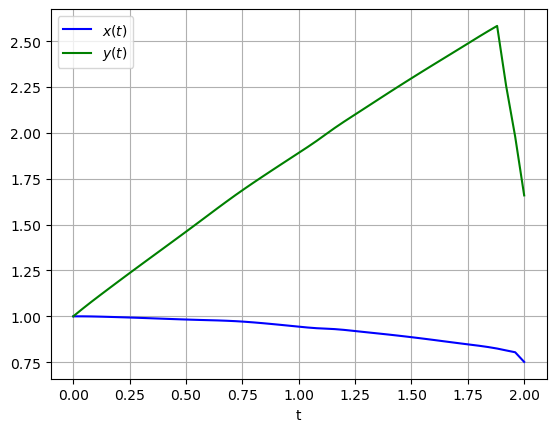

In [67]:
#draw the graphs of solutions x and y
plt.plot(t, sol[:, 0], 'b', label=r'$x(t)$')
plt.plot(t, sol[:, 1], 'g', label=r'$y(t)$')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
#these are the local coordinates x(t) and y(t) of a geodesic evolving with time t